<h1 align=center><font size = 5>Machine Learning models for aiding the decision-making process in emergency departments</font></h1>

<h1>Tabla comparativa de algoritmos<h1>
<h3>Descripción</h3>
<p>
En este script se desarrollará una serie de predicciones basadas en datos del hospital San Juan de Dios Curicó, correspondientes al año 2018 representados por registros de urgencias. El objetivo es predecir, mediante un algoritmo de arboles de desición, la categoría de gravedad de un apciente de urgencias,tomando como input, datos proporcionados por el paciente en la etapa de registro y sus signos vitales registrados en la etapa de triage.
Se correrán algoritmos de prodicción tales como árboles y bosques de desición, regresión logística, support vector machines y redes neuronales. Para finalmente evaluar el rendimiento de cada algoritmo en términos de la predicción, mediante indicadores tales como Acuraccy, F1-Score, Curva ROC, Índice de Jaccard y logloss
</p>

<h1 id="Descripción de datos">Descripción de datos</h1>
<p>
Los datos utilizados fueros proporcionados por el Hospital San Juan de Dios, Curicó, Chile y corresponden a 4.971 registros de pacientes que asistieron a urgencias durante el periodo comprendido entre el 1 de enero de 2018 y agosto de 2019, los datos fueron limpiados y transformados en un script desarrollado previamente
<ul>
    <li>Datos: <a href="https://drive.google.com/open?id=1Bp7_MnK6cGwgBuwIq1a8S4DS_0wVDiAD" target="_blank">https://drive.google.com/open?id=1Bp7_MnK6cGwgBuwIq1a8S4DS_0wVDiAD</a></li>
    <li>Tipo de datos: csv</li>
</ul>
<p>
Las variables presentes en los datos se describen a continuación:
<ul>    
   
   <li><b>PAC_EDAD</b>: corresponde a la edad del paciente en enteros</li>
   <li><b>MOTIVO_CONSULTA</b>: corresponde a la razón por la que el paciente acude al servicio de urgencias string</li>
   <li><b>MEDIO</b>: corresponde al medio de llegada, mediante el que el paciente acude al servicio de urgencias</li>
   <li><b>SEXO</b>: corresponde al sexo del paciente</li>
   <li><b>CAT</b>: corresponde a la categoría de gravedad asignada al paciente en el proceso de Triage</li>
   <li><b>PRESION_SIST</b>: corresponde la presión sistólica del paciente </li>
   <li><b>PRESION_DIAST</b>: corresponde la presióndiastólica del paciente</li>
   <li><b>SATO2</b>: Dato numérico que representa la saturometria del paciente (Nivel de oxigeno en la sangre)</li>
   <li><b>TEMPERATURA</b>: corresponde a la temperatura corporal del paciente en el momento de la categorización</li>
   <li><b>GLASGOW</b>: corresponde a al nivel registrado por el paciente en la escala Glasgow</li>
   <li><b>DM</b>: corresponde si el paciente presenta o no Diabetes Mellitus</li>
   <li><b>EVA</b>: corresponde si se aplica al paciente una evaluación de vias aéreas</li>
   <li><b>HGT</b>: corresponde a la medida de azucar en la sangre del paciente</li>
   <li><b>LCFA</b>: corresponde a si el paciente presenta obstrucción crónica de vías aéreas</li>
   <li><b>FR</b>: corresponde a la frecuencia respiratoria del paciente</li>
   <li><b>HTA</b>: corresponde a si el paciente posee Hipertención Arterial</li>
   <li><b>HORA_INSC</b>: corresponde a la hora en la que el paciente fue categorizado</li>
   <li><b>MIN_INSC</b>: corresponde al minuto en que el paciente fue categorizado</li>
   <li><b>TIEMPO_ESPERA_CAT</b>: corresponde al tiempo que espera el paciente luego de ser registrado, para ser categorizado</li>
      
</ul>
</p>

In [1]:
#Cargar paquetes necesarios

import pandas as pd
from sklearn import preprocessing
from sklearn import metrics
import sklearn as sk  
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#métricas de evaluación
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
#Métodos de tuneo de parámetros
from sklearn.model_selection import GridSearchCV
# Métodos para balancer las clases
from pylab import rcParams
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier
 
from collections import Counter

Lectura de datos

In [2]:
archivo= 'df_definitiva_A.csv'
archivo2='df_cat_soloTexto.csv'
df_cat= pd.read_csv(archivo,encoding='latin-1',sep=",")
df_PCA= pd.read_csv(archivo2,encoding='latin-1',sep=",")

Revisar si hay columnas sin nombre

In [3]:
df_cat=df_cat.loc[:, ~df_cat.columns.str.contains('^Unnamed')]
df_PCA=df_PCA.loc[:, ~df_PCA.columns.str.contains('^Unnamed')]

Dejar solo en una base de datos la variable target

In [4]:
df_PCA.drop(columns =["CAT"], inplace = True)

Seleccionar las variables que se utilizarán

In [5]:
df_cat=df_cat[['ID_PACIENTE', 'PAC_EDAD', 'CAT', 'SATO2', 'TEMPERATURA', 'GLASGOW',
       'EVA', 'HGT', 'FR','SEXO_M', 'SEXO_F', 'DM_D', 'DM_N',
       'DM_S', 'LCFA_D', 'LCFA_N', 'LCFA_S', 'LCFA_D.1', 'LCFA_N.1',
       'LCFA_S.1']]
df_cat.columns

Index(['ID_PACIENTE', 'PAC_EDAD', 'CAT', 'SATO2', 'TEMPERATURA', 'GLASGOW',
       'EVA', 'HGT', 'FR', 'SEXO_M', 'SEXO_F', 'DM_D', 'DM_N', 'DM_S',
       'LCFA_D', 'LCFA_N', 'LCFA_S', 'LCFA_D.1', 'LCFA_N.1', 'LCFA_S.1'],
      dtype='object')

Unir bases de datos horizontalmente

In [6]:
df_cat =  df_cat.join(df_PCA, lsuffix='_caller', rsuffix='_other')

Quitar variables innecesarias

In [7]:
#Quitando DESC_EVENTO
df_cat.drop(columns =["DESC_EVENTO"], inplace = True)

In [8]:
# Limpiando de faltantes las columnas
df_cat.dropna(subset=["ID_PACIENTE_caller"], axis=0, inplace = True)
df_cat.dropna(subset=["ID_PACIENTE_other"], axis=0, inplace = True)

In [9]:
#Quitando ID_PACIENTE
df_cat.drop(columns =["ID_PACIENTE_caller"], inplace = True)
df_cat.drop(columns =["ID_PACIENTE_other"], inplace = True)

Identificar como "y" a la variable target

In [10]:
y = df_cat["CAT"]

Quitar la variable target de la base de datos

In [11]:
#Quitando CAT
df_cat.drop(columns =["CAT"], inplace = True)

In [12]:
df_cat.columns

Index(['PAC_EDAD', 'SATO2', 'TEMPERATURA', 'GLASGOW', 'EVA', 'HGT', 'FR',
       'SEXO_M', 'SEXO_F', 'DM_D',
       ...
       'Desc_290', 'Desc_291', 'Desc_292', 'Desc_293', 'Desc_294', 'Desc_295',
       'Desc_296', 'Desc_297', 'Desc_298', 'Desc_299'],
      dtype='object', length=318)

Asignar a "x" el resto de variables independientes

In [58]:
X=df_cat

In [14]:
X.shape

(6201, 318)

In [15]:
y.shape

(6201,)

 <h1 id="Preprocesamiento de datos">Preprocesamiento de datos</h1>
<p>
Para aplicar el paquete de arboles de desición, los datos deben ser numéricos, en este caso siguen siendo en su mayoría categoricos pero serán transformados a nominales.
</p>

In [16]:
from sklearn import preprocessing

Estardarizar datos

In [17]:
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.98991106, -1.95945278, -1.32149243, ..., -0.7339725 ,
        -0.74815441, -0.08867985],
       [-1.51331674,  0.44052747,  0.43312174, ...,  0.74987735,
         0.129614  ,  2.14388795],
       [-0.52366854,  0.44052747, -0.9705696 , ...,  0.52878175,
        -0.41249443, -0.15640253],
       [-1.45510214,  0.70719194, -0.79510818, ...,  0.2780491 ,
         1.68288137, -0.48549129],
       [ 0.98991106,  0.44052747, -0.09326251, ...,  0.52878175,
        -0.41249443, -0.15640253]])

 <h1 id="Configurando algoritmos">Configurando algoritmos</h1>
<p>
En esta sección se definen parámetros necesarios para la correcta aplicación de los algoritmos a implementar, además de seccionar el conjunto de datos en datos de prueba(30%)y de entrenamiento (70%). Los parámetros escogidos pueden ser modificados con el fin de obtener resultados diferentes
</p>

Carga de paquetes

In [18]:
from sklearn.model_selection import train_test_split

Segmentación del conjunto de datos

In [19]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)

Subsampling

In [20]:
us = NearMiss(sampling_strategy='auto',version=1,n_neighbors=2, n_neighbors_ver3=3,n_jobs=None,)
X_trainset_res_1, y_trainset_res_1 = us.fit_sample(X_trainset, y_trainset)
 
print ("Distribution before resampling {}".format(Counter(y_trainset)))
print ("Distribution after resampling {}".format(Counter(y_trainset_res_1)))

Distribution before resampling Counter({'C3': 3197, 'C2': 1067, 'C4': 72, 'C1': 4})
Distribution after resampling Counter({'C1': 4, 'C2': 4, 'C3': 4, 'C4': 4})


In [21]:
us = NearMiss(sampling_strategy='majority',version=1,n_neighbors=2, n_neighbors_ver3=3,n_jobs=None,)
X_trainset_res_2, y_trainset_res_2 = us.fit_sample(X_trainset, y_trainset)
 
print ("Distribution before resampling {}".format(Counter(y_trainset)))
print ("Distribution after resampling {}".format(Counter(y_trainset_res_2)))

Distribution before resampling Counter({'C3': 3197, 'C2': 1067, 'C4': 72, 'C1': 4})
Distribution after resampling Counter({'C2': 1067, 'C4': 72, 'C1': 4, 'C3': 4})


In [22]:
us = NearMiss(sampling_strategy='not minority',version=1,n_neighbors=2, n_neighbors_ver3=3,n_jobs=None,)
X_trainset_res_3, y_trainset_res_3 = us.fit_sample(X_trainset, y_trainset)
 
print ("Distribution before resampling {}".format(Counter(y_trainset)))
print ("Distribution after resampling {}".format(Counter(y_trainset_res_3)))

Distribution before resampling Counter({'C3': 3197, 'C2': 1067, 'C4': 72, 'C1': 4})
Distribution after resampling Counter({'C1': 4, 'C2': 4, 'C3': 4, 'C4': 4})


In [23]:
us = NearMiss(sampling_strategy='not majority',version=1,n_neighbors=2, n_neighbors_ver3=3,n_jobs=None,)
X_trainset_res_4, y_trainset_res_4 = us.fit_sample(X_trainset, y_trainset)
 
print ("Distribution before resampling {}".format(Counter(y_trainset)))
print ("Distribution after resampling {}".format(Counter(y_trainset_res_4)))

Distribution before resampling Counter({'C3': 3197, 'C2': 1067, 'C4': 72, 'C1': 4})
Distribution after resampling Counter({'C3': 3197, 'C1': 4, 'C2': 4, 'C4': 4})


In [24]:
us = NearMiss(sampling_strategy='all',version=1,n_neighbors=2, n_neighbors_ver3=3,n_jobs=None,)
X_trainset_res_5, y_trainset_res_5 = us.fit_sample(X_trainset, y_trainset)
 
print ("Distribution before resampling {}".format(Counter(y_trainset)))
print ("Distribution after resampling {}".format(Counter(y_trainset_res_5)))

Distribution before resampling Counter({'C3': 3197, 'C2': 1067, 'C4': 72, 'C1': 4})
Distribution after resampling Counter({'C1': 4, 'C2': 4, 'C3': 4, 'C4': 4})


Oversampling

In [25]:
os =  RandomOverSampler(sampling_strategy='auto', random_state=None)
X_trainset_res_A, y_trainset_res_A = os.fit_sample(X_trainset, y_trainset)
 
print ("Distribution before resampling {}".format(Counter(y_trainset)))
print ("Distribution labels after resampling {}".format(Counter(y_trainset_res_A)))

Distribution before resampling Counter({'C3': 3197, 'C2': 1067, 'C4': 72, 'C1': 4})
Distribution labels after resampling Counter({'C3': 3197, 'C2': 3197, 'C4': 3197, 'C1': 3197})


In [26]:
os =  RandomOverSampler(sampling_strategy='not minority', random_state=None)
X_trainset_res_C, y_trainset_res_C = os.fit_sample(X_trainset, y_trainset)
 
print ("Distribution before resampling {}".format(Counter(y_trainset)))
print ("Distribution labels after resampling {}".format(Counter(y_trainset_res_C)))

Distribution before resampling Counter({'C3': 3197, 'C2': 1067, 'C4': 72, 'C1': 4})
Distribution labels after resampling Counter({'C3': 3197, 'C2': 3197, 'C4': 3197, 'C1': 4})


In [27]:
os =  RandomOverSampler(sampling_strategy='not majority', random_state=None)
X_trainset_res_D, y_trainset_res_D = os.fit_sample(X_trainset, y_trainset)
 
print ("Distribution before resampling {}".format(Counter(y_trainset)))
print ("Distribution labels after resampling {}".format(Counter(y_trainset_res_D)))

Distribution before resampling Counter({'C3': 3197, 'C2': 1067, 'C4': 72, 'C1': 4})
Distribution labels after resampling Counter({'C3': 3197, 'C2': 3197, 'C4': 3197, 'C1': 3197})


In [28]:
os =  RandomOverSampler(sampling_strategy='all', random_state=None)
X_trainset_res_E, y_trainset_res_E = os.fit_sample(X_trainset, y_trainset)
 
print ("Distribution before resampling {}".format(Counter(y_trainset)))
print ("Distribution labels after resampling {}".format(Counter(y_trainset_res_E)))

Distribution before resampling Counter({'C3': 3197, 'C2': 1067, 'C4': 72, 'C1': 4})
Distribution labels after resampling Counter({'C3': 3197, 'C2': 3197, 'C4': 3197, 'C1': 3197})


SMOTE-Tomek

In [29]:
os_us = SMOTETomek(sampling_strategy='auto',random_state=None,smote=None,tomek=None,n_jobs=None,)
X_trainset_res_ST1, y_trainset_res_ST1 = os.fit_sample(X_trainset, y_trainset)
 
print ("Distribution before resampling {}".format(Counter(y_trainset)))
print ("Distribution labels after resampling {}".format(Counter(y_trainset_res_ST1)))

Distribution before resampling Counter({'C3': 3197, 'C2': 1067, 'C4': 72, 'C1': 4})
Distribution labels after resampling Counter({'C3': 3197, 'C2': 3197, 'C4': 3197, 'C1': 3197})


In [30]:
os_us = SMOTETomek(sampling_strategy='majority',random_state=None,smote=None,tomek=None,n_jobs=None,)
X_trainset_res_ST2, y_trainset_res_ST2 = os.fit_sample(X_trainset, y_trainset)
 
print ("Distribution before resampling {}".format(Counter(y_trainset)))
print ("Distribution labels after resampling {}".format(Counter(y_trainset_res_ST2)))

Distribution before resampling Counter({'C3': 3197, 'C2': 1067, 'C4': 72, 'C1': 4})
Distribution labels after resampling Counter({'C3': 3197, 'C2': 3197, 'C4': 3197, 'C1': 3197})


In [31]:
os_us = SMOTETomek(sampling_strategy='not minority',random_state=None,smote=None,tomek=None,n_jobs=None,)
X_trainset_res_ST3, y_trainset_res_ST3 = os.fit_sample(X_trainset, y_trainset)
 
print ("Distribution before resampling {}".format(Counter(y_trainset)))
print ("Distribution labels after resampling {}".format(Counter(y_trainset_res_ST3)))

Distribution before resampling Counter({'C3': 3197, 'C2': 1067, 'C4': 72, 'C1': 4})
Distribution labels after resampling Counter({'C3': 3197, 'C2': 3197, 'C4': 3197, 'C1': 3197})


In [32]:
os_us = SMOTETomek(sampling_strategy='not majority',random_state=None,smote=None,tomek=None,n_jobs=None,)
X_trainset_res_ST4, y_trainset_res_ST4 = os.fit_sample(X_trainset, y_trainset)
 
print ("Distribution before resampling {}".format(Counter(y_trainset)))
print ("Distribution labels after resampling {}".format(Counter(y_trainset_res_ST4)))

Distribution before resampling Counter({'C3': 3197, 'C2': 1067, 'C4': 72, 'C1': 4})
Distribution labels after resampling Counter({'C3': 3197, 'C2': 3197, 'C4': 3197, 'C1': 3197})


In [33]:
os_us = SMOTETomek(sampling_strategy='all',random_state=None,smote=None,tomek=None,n_jobs=None,)
X_trainset_res_ST5, y_trainset_res_ST5 = os.fit_sample(X_trainset, y_trainset)
 
print ("Distribution before resampling {}".format(Counter(y_trainset)))
print ("Distribution labels after resampling {}".format(Counter(y_trainset_res_ST5)))

Distribution before resampling Counter({'C3': 3197, 'C2': 1067, 'C4': 72, 'C1': 4})
Distribution labels after resampling Counter({'C3': 3197, 'C2': 3197, 'C4': 3197, 'C1': 3197})


Árbol de desición

In [34]:
from sklearn.tree import DecisionTreeClassifier

In [36]:
DT= DecisionTreeClassifier(criterion="entropy", max_depth = 4)
DT.fit(X_trainset,y_trainset)
DT_Ss1=DecisionTreeClassifier(criterion="entropy", max_depth = 4).fit(X_trainset_res_1,y_trainset_res_1)
DT_Ss2=DecisionTreeClassifier(criterion="entropy", max_depth = 4).fit(X_trainset_res_2,y_trainset_res_2)
DT_Ss3=DecisionTreeClassifier(criterion="entropy", max_depth = 4).fit(X_trainset_res_3,y_trainset_res_3)
DT_Ss4=DecisionTreeClassifier(criterion="entropy", max_depth = 4).fit(X_trainset_res_4,y_trainset_res_4)
DT_Ss5=DecisionTreeClassifier(criterion="entropy", max_depth = 4).fit(X_trainset_res_5,y_trainset_res_5)
DT_OsA=DecisionTreeClassifier(criterion="entropy", max_depth = 4).fit(X_trainset_res_A,y_trainset_res_A)
DT_OsC=DecisionTreeClassifier(criterion="entropy", max_depth = 4).fit(X_trainset_res_C,y_trainset_res_C)
DT_OsD=DecisionTreeClassifier(criterion="entropy", max_depth = 4).fit(X_trainset_res_D,y_trainset_res_D)
DT_OsE=DecisionTreeClassifier(criterion="entropy", max_depth = 4).fit(X_trainset_res_E,y_trainset_res_E)
DT_ST1=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=13, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0,min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0,
                       random_state=42, splitter='best').fit(X_trainset_res_ST1,y_trainset_res_ST1)
DT_ST2=DecisionTreeClassifier(criterion="entropy", max_depth = 4).fit(X_trainset_res_ST2,y_trainset_res_ST2)
DT_ST3=DecisionTreeClassifier(criterion="entropy", max_depth = 4).fit(X_trainset_res_ST3,y_trainset_res_ST3)
DT_ST4=DecisionTreeClassifier(criterion="entropy", max_depth = 4).fit(X_trainset_res_ST4,y_trainset_res_ST4)
DT_ST5=DecisionTreeClassifier(criterion="entropy", max_depth = 4).fit(X_trainset_res_ST5,y_trainset_res_ST5)

In [37]:
yhat_1 = DT.predict(X_testset)
print (classification_report(y_testset, yhat_1))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.97      0.42      0.59       456
          C3       0.83      1.00      0.90      1380
          C4       0.00      0.00      0.00        23

    accuracy                           0.84      1861
   macro avg       0.45      0.35      0.37      1861
weighted avg       0.85      0.84      0.81      1861



C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
yhat_1_1 =DT_Ss1.predict(X_testset)
print (classification_report(y_testset, yhat_1_1))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.71      0.08      0.14       456
          C3       0.42      0.02      0.03      1380
          C4       0.01      1.00      0.03        23

    accuracy                           0.04      1861
   macro avg       0.29      0.27      0.05      1861
weighted avg       0.48      0.04      0.06      1861



C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
yhat_1_2 = DT_Ss2.predict(X_testset)
print (classification_report(y_testset, yhat_1_2))


              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.25      1.00      0.39       456
          C3       0.00      0.00      0.00      1380
          C4       0.00      0.00      0.00        23

    accuracy                           0.25      1861
   macro avg       0.06      0.25      0.10      1861
weighted avg       0.06      0.25      0.10      1861



C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
yhat_1_3 = DT_Ss3.predict(X_testset)
print (classification_report(y_testset, yhat_1_3))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.71      0.08      0.14       456
          C3       0.42      0.02      0.03      1380
          C4       0.01      1.00      0.03        23

    accuracy                           0.04      1861
   macro avg       0.29      0.27      0.05      1861
weighted avg       0.48      0.04      0.06      1861



C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
yhat_1_4 = DT_Ss4.predict(X_testset)
print (classification_report(y_testset, yhat_1_4))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.33      0.00      0.00       456
          C3       0.74      1.00      0.85      1380
          C4       0.00      0.00      0.00        23

    accuracy                           0.74      1861
   macro avg       0.27      0.25      0.21      1861
weighted avg       0.63      0.74      0.63      1861



C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
yhat_1_5 = DT_Ss5.predict(X_testset)
print (classification_report(y_testset, yhat_1_5))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.63      0.06      0.11       456
          C3       0.34      0.01      0.03      1380
          C4       0.01      1.00      0.03        23

    accuracy                           0.04      1861
   macro avg       0.24      0.27      0.04      1861
weighted avg       0.41      0.04      0.05      1861



C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
yhat_1_A = DT_OsA.predict(X_testset)
print (classification_report(y_testset, yhat_1_A))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.47      0.54      0.51       456
          C3       0.79      0.14      0.23      1380
          C4       0.02      0.78      0.03        23

    accuracy                           0.24      1861
   macro avg       0.32      0.37      0.19      1861
weighted avg       0.70      0.24      0.30      1861



C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
yhat_1_C = DT_OsC.predict(X_testset)
print (classification_report(y_testset, yhat_1_C))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.87      0.43      0.57       456
          C3       0.81      0.28      0.42      1380
          C4       0.02      0.83      0.03        23

    accuracy                           0.32      1861
   macro avg       0.42      0.38      0.26      1861
weighted avg       0.81      0.32      0.45      1861



C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
yhat_1_D = DT_OsD.predict(X_testset)
print (classification_report(y_testset, yhat_1_D))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.47      0.54      0.51       456
          C3       0.79      0.14      0.23      1380
          C4       0.02      0.78      0.03        23

    accuracy                           0.24      1861
   macro avg       0.32      0.37      0.19      1861
weighted avg       0.70      0.24      0.30      1861



C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
yhat_1_E = DT_OsE.predict(X_testset)
print (classification_report(y_testset, yhat_1_E))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.47      0.54      0.51       456
          C3       0.79      0.14      0.23      1380
          C4       0.02      0.78      0.03        23

    accuracy                           0.24      1861
   macro avg       0.32      0.37      0.19      1861
weighted avg       0.70      0.24      0.30      1861



C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
yhat_1_ST1 = DT_ST1.predict(X_testset)
print (classification_report(y_testset, yhat_1_ST1))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.51      0.54      0.52       456
          C3       0.82      0.67      0.74      1380
          C4       0.03      0.35      0.06        23

    accuracy                           0.63      1861
   macro avg       0.34      0.39      0.33      1861
weighted avg       0.73      0.63      0.67      1861



C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
yhat_1_ST2 = DT_ST2.predict(X_testset)
print (classification_report(y_testset, yhat_1_ST2))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.47      0.54      0.51       456
          C3       0.79      0.14      0.23      1380
          C4       0.02      0.78      0.03        23

    accuracy                           0.24      1861
   macro avg       0.32      0.37      0.19      1861
weighted avg       0.70      0.24      0.30      1861



C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
yhat_1_ST3 = DT_ST3.predict(X_testset)
print (classification_report(y_testset, yhat_1_ST3))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.47      0.54      0.51       456
          C3       0.79      0.14      0.23      1380
          C4       0.02      0.78      0.03        23

    accuracy                           0.24      1861
   macro avg       0.32      0.37      0.19      1861
weighted avg       0.70      0.24      0.30      1861



C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
yhat_1_ST4 = DT.predict(X_testset)
print (classification_report(y_testset, yhat_1_ST4))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.97      0.42      0.59       456
          C3       0.83      1.00      0.90      1380
          C4       0.00      0.00      0.00        23

    accuracy                           0.84      1861
   macro avg       0.45      0.35      0.37      1861
weighted avg       0.85      0.84      0.81      1861



C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
yhat_1_ST5 = DT_ST5.predict(X_testset)
print (classification_report(y_testset, yhat_1_ST5))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.47      0.54      0.51       456
          C3       0.79      0.11      0.20      1380
          C4       0.02      0.78      0.03        23

    accuracy                           0.23      1861
   macro avg       0.32      0.36      0.18      1861
weighted avg       0.70      0.23      0.27      1861



C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
yhat_prob_1=DT.predict_proba(X_testset)
DT_Acc=round(metrics.accuracy_score(y_testset,  yhat_1),4)
DT_F1=f1_score(y_testset, yhat_1, average='weighted') 

Mejores parámetros obtenidos a travez de grid search

In [53]:
DT_GS =DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=13, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0,min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0,
                       random_state=42, splitter='best')
DT_GS.fit(X_trainset,y_trainset)


DecisionTreeClassifier(criterion='entropy', max_depth=13, random_state=42)

Aplicación de grid search

In [ ]:
DT_parameters = [{'criterion': ['entropy', 'gini'], 'max_depth': np.arange(3, 21)},{'min_samples_leaf': [2,5, 10, 20, 50, 100]}]
DT_GS = GridSearchCV(DecisionTreeClassifier(random_state=42), DT_parameters, verbose=1, cv=5, scoring='balanced_accuracy')
DT_GS.fit(X_trainset,y_trainset)

In [ ]:
DT_GS.best_estimator_

In [54]:
yhat_1_GS= DT_GS.predict(X_testset)
DT_Acc_GS=round(metrics.accuracy_score(y_testset, yhat_1_GS),4)
DT_Acc_ST1=round(metrics.accuracy_score(y_testset, yhat_1_ST1),4)
DT_F1_GS=round(f1_score(y_testset, yhat_1_GS, average='weighted'),4) 
DT_F1_ST1=round(f1_score(y_testset, yhat_1_ST1, average='weighted'),4) 

In [55]:
resultados_DT = {'índices de rendimiento':['Accuracy','F1-Score'],
             'Árboles de decisión':[DT_Acc,DT_F1],
             'Grid Search':[DT_Acc_GS,DT_F1_GS],
             'Smote-Tomek':[DT_Acc_ST1,DT_F1_ST1]}
Tabla_resultados_DT=pd.DataFrame(resultados_DT)
print(Tabla_resultados_DT)

  índices de rendimiento  Árboles de decisión  Grid Search  Smote-Tomek
0               Accuracy             0.842000       0.8313       0.6287
1               F1-Score             0.814007       0.8155       0.6738


Importación de paquete eli5 para aplicar técnica de "Permutation Importance"

In [56]:
import eli5
from eli5.sklearn import PermutationImportance

In [58]:
X=df_cat

In [ ]:
perm = PermutationImportance(DT, random_state=1).fit(X, y)
eli5.show_weights(perm, feature_names =X.columns.tolist())

In [61]:
perm = PermutationImportance(DT_GS, random_state=1).fit(X, y)
eli5.show_weights(perm, feature_names =X.columns.tolist())

C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier 

Weight,Feature
0 ± 0.0000,Desc_63
0 ± 0.0000,Desc_97
0 ± 0.0000,Desc_96
0 ± 0.0000,Desc_95
0 ± 0.0000,Desc_94
0 ± 0.0000,Desc_93
0 ± 0.0000,Desc_92
0 ± 0.0000,Desc_91
0 ± 0.0000,Desc_90
0 ± 0.0000,Desc_89


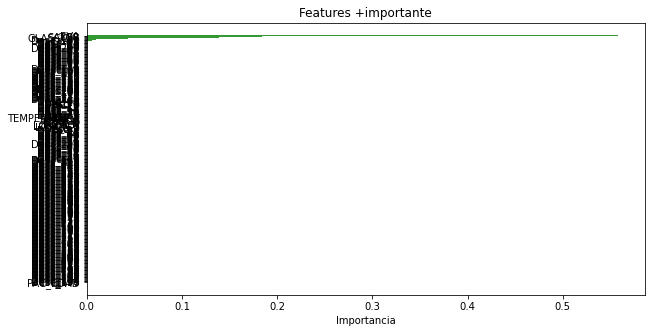

In [62]:
feat_importances = DT.feature_importances_
indices = np.argsort(feat_importances)
features = X.columns
plt.figure(figsize=(10,5))
plt.title('Features +importante')
plt.barh(range(len(indices)), feat_importances[indices], color='g', align='center',linestyle="solid",alpha=0.8)
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Importancia')
plt.show()

Importación de paquetes para aplicar SHAP values

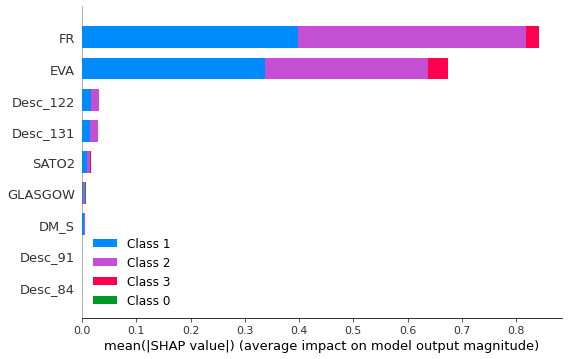

In [68]:
import shap
ex = shap.TreeExplainer(DT)
shap_values = ex.shap_values(X)
shap.summary_plot(shap_values, X,max_display=9)

In [65]:
conda install -c conda-forge pdpbox

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\jmoya\Anaconda3

  added / updated specs:
    - pdpbox


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pdpbox-0.2.1               |     pyhd8ed1ab_0        22.2 MB  conda-forge
    scikit-learn-1.0.2         |   py39hf11a4ad_1         5.1 MB
    ------------------------------------------------------------
                                           Total:        27.3 MB

The following NEW packages will be INSTALLED:

  pdpbox             conda-forge/noarch::pdpbox-0.2.1-pyhd8ed1ab_0
  scikit-learn       pkgs/main/win-64::scikit-learn-1.0.2-py39hf11a4ad_1




scikit-learn-1.0.2   | 5.1 MB    |            |   0% 
scikit-learn-1.0.2   | 5.1 MB    |            |   0% 
scikit-learn-1.0.2   | 5.1 MB    | 3          |   3% 
scikit-learn-1.0.2   | 5.1 MB    | 6          |   6% 
scikit-learn-1.0.2   | 5


The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/win-64::anaconda==custom=py39_1
  - conda-forge/noarch::eli5==0.13.0=pyhd8ed1ab_0
  - conda-forge/noarch::imbalanced-learn==0.7.0=py_1
  - defaults/win-64::scikit-learn-intelex==2021.3.0=py39haa95532_0
  - defaults/win-64::_anaconda_depends==2022.05=py39_0


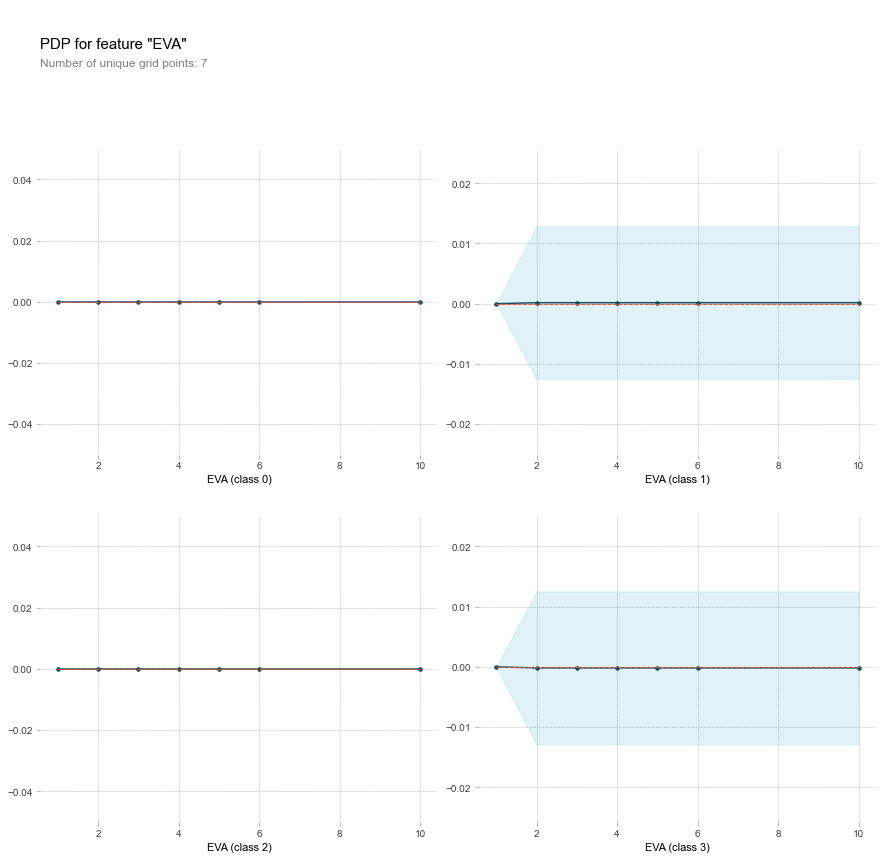

In [69]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=DT_GS, dataset=X, model_features=X.columns, feature='EVA')

# plot it
pdp.pdp_plot(pdp_goals, 'EVA')
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

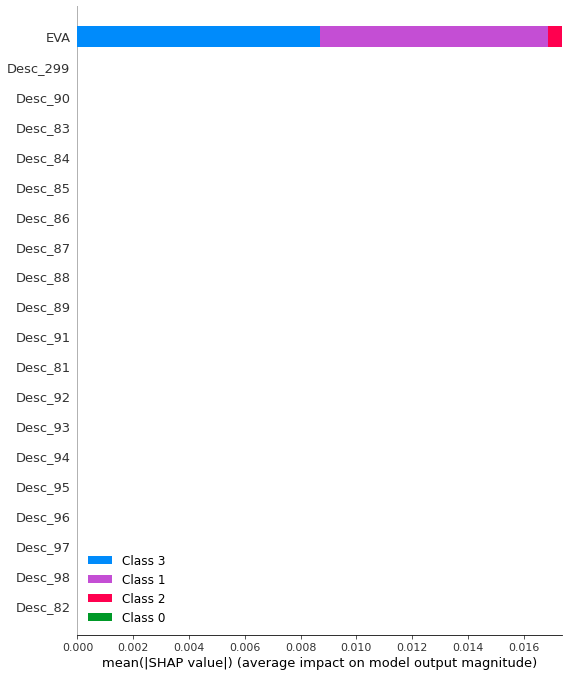

In [70]:
# Kerner Explainer
explainer = shap.KernelExplainer(DT.predict_proba,X[:100])
shap_values = explainer.shap_values(X[:100])
shap.summary_plot(shap_values, X[:100])

In [71]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[0], X)

In [72]:
shap.initjs()
columIndex= 2
shap.force_plot(explainer.expected_value[1], shap_values[1][columIndex,:], X.iloc[columIndex,:], link="logit")

Bosque de desición

In [73]:
from sklearn.ensemble import RandomForestClassifier
RF= RandomForestClassifier(max_depth=2, random_state=0)
RF.fit(X_trainset,y_trainset)

RandomForestClassifier(max_depth=2, random_state=0)

In [76]:
RF_Ss1= RandomForestClassifier(max_depth=2, random_state=0).fit(X_trainset_res_1,y_trainset_res_1)
RF_Ss2= RandomForestClassifier(max_depth=2, random_state=0).fit(X_trainset_res_2,y_trainset_res_2)
RF_Ss3= RandomForestClassifier(max_depth=2, random_state=0).fit(X_trainset_res_3,y_trainset_res_3)
RF_Ss4= RandomForestClassifier(max_depth=2, random_state=0).fit(X_trainset_res_4,y_trainset_res_4)
RF_Ss5= RandomForestClassifier(max_depth=2, random_state=0).fit(X_trainset_res_5,y_trainset_res_5)
RF_OsA= RandomForestClassifier(max_depth=2, random_state=0).fit(X_trainset_res_A,y_trainset_res_A)
RF_OsC= RandomForestClassifier(max_depth=2, random_state=0).fit(X_trainset_res_C,y_trainset_res_C)
RF_OsD= RandomForestClassifier(max_depth=2, random_state=0).fit(X_trainset_res_D,y_trainset_res_D)
RF_OsE= RandomForestClassifier(max_depth=2, random_state=0).fit(X_trainset_res_E,y_trainset_res_E)
RF_ST1= RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=13, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False).fit(X_trainset_res_ST1,y_trainset_res_ST1)
RF_ST2= RandomForestClassifier(max_depth=2, random_state=0).fit(X_trainset_res_ST2,y_trainset_res_ST2)
RF_ST3= RandomForestClassifier(max_depth=2, random_state=0).fit(X_trainset_res_ST3,y_trainset_res_ST3)
RF_ST4= RandomForestClassifier(max_depth=2, random_state=0).fit(X_trainset_res_ST4,y_trainset_res_ST4)
RF_ST5= RandomForestClassifier(max_depth=2, random_state=0).fit(X_trainset_res_ST5,y_trainset_res_ST5)

In [77]:
yhat_2 = RF.predict(X_testset)
print (classification_report(y_testset, yhat_2))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.00      0.00      0.00       456
          C3       0.74      1.00      0.85      1380
          C4       0.00      0.00      0.00        23

    accuracy                           0.74      1861
   macro avg       0.19      0.25      0.21      1861
weighted avg       0.55      0.74      0.63      1861



In [78]:
yhat_2_1 = RF_Ss1.predict(X_testset)
print (classification_report(y_testset, yhat_2_1))

              precision    recall  f1-score   support

          C1       0.00      0.50      0.00         2
          C2       0.37      0.13      0.20       456
          C3       0.67      0.12      0.21      1380
          C4       0.02      0.35      0.04        23

    accuracy                           0.13      1861
   macro avg       0.27      0.28      0.11      1861
weighted avg       0.59      0.13      0.20      1861



In [79]:
yhat_2_2 = RF_Ss2.predict(X_testset)
print (classification_report(y_testset, yhat_2_2))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.25      1.00      0.39       456
          C3       0.00      0.00      0.00      1380
          C4       0.00      0.00      0.00        23

    accuracy                           0.25      1861
   macro avg       0.06      0.25      0.10      1861
weighted avg       0.06      0.25      0.10      1861



In [80]:
yhat_2_3 = RF_Ss3.predict(X_testset)
print (classification_report(y_testset, yhat_2_3))

              precision    recall  f1-score   support

          C1       0.00      0.50      0.00         2
          C2       0.37      0.13      0.20       456
          C3       0.67      0.12      0.21      1380
          C4       0.02      0.35      0.04        23

    accuracy                           0.13      1861
   macro avg       0.27      0.28      0.11      1861
weighted avg       0.59      0.13      0.20      1861



In [81]:
yhat_2_4 = RF_Ss4.predict(X_testset)
print (classification_report(y_testset, yhat_2_4))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.00      0.00      0.00       456
          C3       0.74      1.00      0.85      1380
          C4       0.00      0.00      0.00        23

    accuracy                           0.74      1861
   macro avg       0.19      0.25      0.21      1861
weighted avg       0.55      0.74      0.63      1861



In [82]:
yhat_2_5 = RF_Ss5.predict(X_testset)
print (classification_report(y_testset, yhat_2_5))

              precision    recall  f1-score   support

          C1       0.00      0.50      0.00         2
          C2       0.37      0.13      0.19       456
          C3       0.66      0.12      0.20      1380
          C4       0.02      0.35      0.04        23

    accuracy                           0.12      1861
   macro avg       0.26      0.27      0.11      1861
weighted avg       0.58      0.12      0.20      1861



In [83]:
yhat_2_A = RF_OsA.predict(X_testset)
print (classification_report(y_testset, yhat_2_A))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.30      0.50      0.38       456
          C3       0.87      0.09      0.16      1380
          C4       0.02      0.65      0.04        23

    accuracy                           0.20      1861
   macro avg       0.30      0.31      0.14      1861
weighted avg       0.72      0.20      0.21      1861



In [84]:
yhat_2_C = RF_OsC.predict(X_testset)
print (classification_report(y_testset, yhat_2_C))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.31      0.68      0.42       456
          C3       0.88      0.10      0.18      1380
          C4       0.02      0.61      0.04        23

    accuracy                           0.25      1861
   macro avg       0.30      0.35      0.16      1861
weighted avg       0.73      0.25      0.24      1861



In [85]:
yhat_2_D = RF_OsD.predict(X_testset)
print (classification_report(y_testset, yhat_2_D))

              precision    recall  f1-score   support

          C1       0.00      0.50      0.01         2
          C2       0.33      0.40      0.36       456
          C3       0.87      0.14      0.24      1380
          C4       0.02      0.65      0.04        23

    accuracy                           0.21      1861
   macro avg       0.31      0.42      0.16      1861
weighted avg       0.72      0.21      0.26      1861



In [86]:
yhat_2_E = RF_OsE.predict(X_testset)
print (classification_report(y_testset, yhat_2_E))

              precision    recall  f1-score   support

          C1       0.00      0.50      0.00         2
          C2       0.34      0.30      0.32       456
          C3       0.89      0.09      0.16      1380
          C4       0.02      0.65      0.04        23

    accuracy                           0.15      1861
   macro avg       0.31      0.39      0.13      1861
weighted avg       0.75      0.15      0.20      1861



In [87]:
yhat_2_ST1 = RF_ST1.predict(X_testset)
print (classification_report(y_testset, yhat_2_ST1 ))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.63      0.55      0.58       456
          C3       0.85      0.84      0.84      1380
          C4       0.04      0.17      0.07        23

    accuracy                           0.76      1861
   macro avg       0.38      0.39      0.37      1861
weighted avg       0.78      0.76      0.77      1861



In [88]:
yhat_2_ST2 = RF_ST2.predict(X_testset)
print (classification_report(y_testset, yhat_2_ST2 ))

              precision    recall  f1-score   support

          C1       0.00      0.50      0.01         2
          C2       0.31      0.42      0.36       456
          C3       0.86      0.09      0.16      1380
          C4       0.02      0.70      0.04        23

    accuracy                           0.18      1861
   macro avg       0.30      0.43      0.14      1861
weighted avg       0.72      0.18      0.21      1861



In [89]:
yhat_2_ST3 = RF_ST3.predict(X_testset)
print (classification_report(y_testset, yhat_2_ST3 ))

              precision    recall  f1-score   support

          C1       0.00      0.50      0.00         2
          C2       0.37      0.28      0.32       456
          C3       0.87      0.13      0.22      1380
          C4       0.02      0.65      0.04        23

    accuracy                           0.17      1861
   macro avg       0.32      0.39      0.15      1861
weighted avg       0.73      0.17      0.25      1861



In [90]:
yhat_2_ST4 = RF_ST4.predict(X_testset)
print (classification_report(y_testset, yhat_2_ST4 ))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.30      0.47      0.37       456
          C3       0.84      0.09      0.17      1380
          C4       0.02      0.65      0.04        23

    accuracy                           0.19      1861
   macro avg       0.29      0.30      0.14      1861
weighted avg       0.69      0.19      0.21      1861



In [91]:
yhat_2_ST5 = RF_ST5.predict(X_testset)
print (classification_report(y_testset, yhat_2_ST5 ))

              precision    recall  f1-score   support

          C1       0.00      0.50      0.00         2
          C2       0.33      0.30      0.31       456
          C3       0.88      0.06      0.11      1380
          C4       0.02      0.65      0.04        23

    accuracy                           0.13      1861
   macro avg       0.31      0.38      0.12      1861
weighted avg       0.73      0.13      0.16      1861



In [92]:
yhat_prob_2=RF.predict_proba(X_testset)
RF_Acc=round(metrics.accuracy_score(y_testset, yhat_2),4)
#RF_Jcc=round(jaccard_similarity_score(y_testset, yhat_2),4)
RF_F1=f1_score(y_testset, yhat_2, average='weighted') 
RF_lgl=round(log_loss(y_testset, yhat_prob_2),4)

In [97]:
RF_GS=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=13, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
RF_GS.fit(X_trainset,y_trainset)

RandomForestClassifier(max_depth=13, max_features='auto', n_estimators=300,
                       random_state=0)

In [95]:
RF_parameters ={ 'n_estimators': [100,200,300,400,500],'criterion': ['entropy', 'gini'], 'max_depth': np.arange(3, 21)},{'min_samples_leaf': [2,5, 10, 20, 50, 100]}
RF_GS = GridSearchCV(estimator=RF,param_grid=RF_parameters, cv= 5,scoring="accuracy")
RF_GS.fit(X_trainset,y_trainset)

KeyboardInterrupt: 

In [ ]:
RF_GS.best_estimator_

In [98]:
yhat_2_GS= RF_GS.predict(X_testset)
yhat_prob_2_GS=RF_GS.predict_proba(X_testset)
RF_Acc_GS=round(metrics.accuracy_score(y_testset, yhat_2_GS),4)
RF_Acc_ST1=round(metrics.accuracy_score(y_testset, yhat_2_ST1),4)
#RF_Jcc_GS=round(jaccard_similarity_score(y_testset, yhat_2_GS),4)
#RF_lgl_GS=round(log_loss(y_testset, yhat_prob_2_GS),4)
RF_F1_GS=round(f1_score(y_testset, yhat_2_GS, average='weighted'),4) 
RF_F1_ST1=round(f1_score(y_testset, yhat_2_ST1, average='weighted'),4) 

In [99]:
resultados_RF = {'índices de rendimiento':['Accuracy','F1-Score'],
             'Bosque de decisión':[RF_Acc, RF_F1],
             'Grid Search':[RF_Acc_GS,RF_F1_GS],
                'Smote Tomek':[RF_Acc_ST1,RF_F1_ST1]}
Tabla_resultados_RF=pd.DataFrame(resultados_RF)
print(Tabla_resultados_RF)

  índices de rendimiento  Bosque de decisión  Grid Search  Smote Tomek
0               Accuracy            0.741500       0.8286       0.7603
1               F1-Score            0.631485       0.7969       0.7707


In [100]:
perm = PermutationImportance(RF_GS, random_state=1).fit(X, y)
eli5.show_weights(perm, feature_names =X.columns.tolist())

Weight,Feature
0.0038 ± 0.0050,EVA
0 ± 0.0000,Desc_99
0 ± 0.0000,Desc_85
0 ± 0.0000,Desc_86
0 ± 0.0000,Desc_87
0 ± 0.0000,Desc_88
0 ± 0.0000,Desc_89
0 ± 0.0000,Desc_90
0 ± 0.0000,Desc_83
0 ± 0.0000,Desc_82


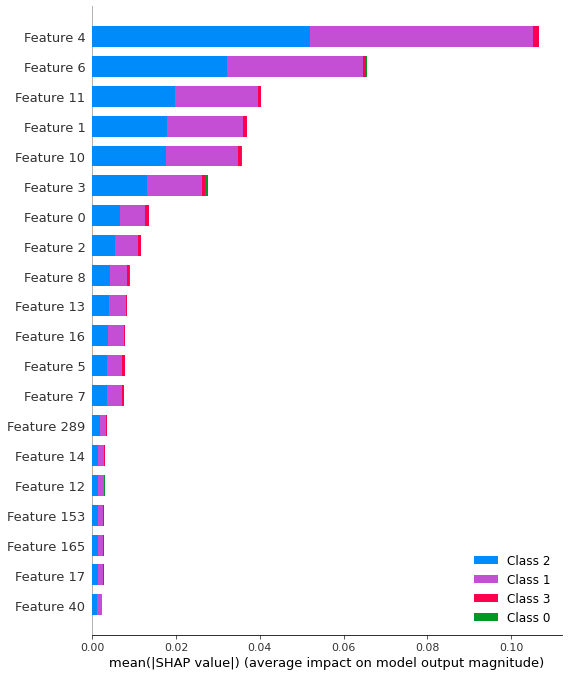

In [101]:
#import shap
ex = shap.TreeExplainer(RF_GS)
shap_values = ex.shap_values(X_testset)
shap.summary_plot(shap_values, X_testset)

  0%|          | 0/100 [00:00<?, ?it/s]

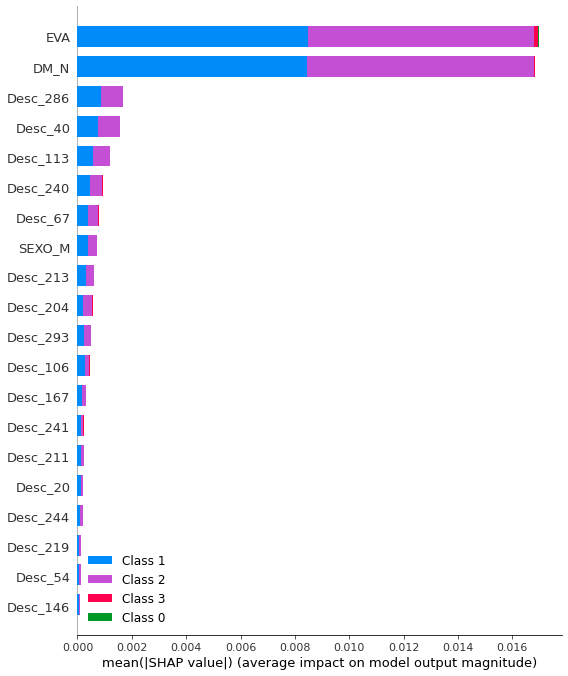

In [102]:
# Kerner Explainer
explainer = shap.KernelExplainer(RF.predict_proba,X[:100])
shap_values = explainer.shap_values(X[:100])
shap.summary_plot(shap_values, X[:100])

Regresión logística (multi-class)

In [103]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(multi_class='ovr',class_weight='balanced', max_iter=1000,penalty='l2',C=1).fit(X_trainset,y_trainset)

In [104]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(multi_class='ovr',class_weight='balanced', max_iter=1000,penalty='l2',C=1).fit(X_trainset,y_trainset)
LR_Ss1 = LogisticRegression(multi_class='ovr',class_weight='balanced', max_iter=1000).fit(X_trainset_res_1,y_trainset_res_1)
LR_Ss2 = LogisticRegression(multi_class='ovr',class_weight='balanced', max_iter=1000).fit(X_trainset_res_2,y_trainset_res_2)
LR_Ss3 = LogisticRegression(multi_class='ovr',class_weight='balanced', max_iter=1000).fit(X_trainset_res_3,y_trainset_res_3)
LR_Ss4 = LogisticRegression(multi_class='ovr',class_weight='balanced', max_iter=1000).fit(X_trainset_res_4,y_trainset_res_4)
LR_Ss5 = LogisticRegression(multi_class='ovr',class_weight='balanced', max_iter=1000).fit(X_trainset_res_5,y_trainset_res_5)
LR_OsA = LogisticRegression(multi_class='ovr',class_weight='balanced', max_iter=1000).fit(X_trainset_res_A,y_trainset_res_A)
LR_OsC = LogisticRegression(multi_class='ovr',class_weight='balanced', max_iter=1000).fit(X_trainset_res_C,y_trainset_res_C)
LR_OsD = LogisticRegression(multi_class='ovr',class_weight='balanced', max_iter=1000).fit(X_trainset_res_D,y_trainset_res_D)
LR_OsE = LogisticRegression(multi_class='ovr',class_weight='balanced', max_iter=1000).fit(X_trainset_res_E,y_trainset_res_E)
LR_ST1 = LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False).fit(X_trainset_res_ST1,y_trainset_res_ST1)
LR_ST2 = LogisticRegression(multi_class='ovr',class_weight='balanced', max_iter=1000).fit(X_trainset_res_ST2,y_trainset_res_ST2)
LR_ST3 = LogisticRegression(multi_class='ovr',class_weight='balanced', max_iter=1000).fit(X_trainset_res_ST3,y_trainset_res_ST3)
LR_ST4 = LogisticRegression(multi_class='ovr',class_weight='balanced', max_iter=1000).fit(X_trainset_res_ST4,y_trainset_res_ST4)
LR_ST5 = LogisticRegression(multi_class='ovr',class_weight='balanced', max_iter=1000).fit(X_trainset_res_ST5,y_trainset_res_ST5)

In [105]:
yhat_3= LR.predict(X_testset)
print (classification_report(y_testset, yhat_3))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.48      0.63      0.55       456
          C3       0.87      0.66      0.75      1380
          C4       0.02      0.22      0.04        23

    accuracy                           0.65      1861
   macro avg       0.34      0.38      0.33      1861
weighted avg       0.76      0.65      0.69      1861



In [106]:
yhat_3_1= LR_Ss1.predict(X_testset)
print (classification_report(y_testset, yhat_3_1))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.59      0.07      0.13       456
          C3       0.50      0.04      0.07      1380
          C4       0.01      1.00      0.03        23

    accuracy                           0.06      1861
   macro avg       0.28      0.28      0.06      1861
weighted avg       0.52      0.06      0.08      1861



In [107]:
yhat_3_2= LR_Ss2.predict(X_testset)
print (classification_report(y_testset, yhat_3_2))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.32      0.75      0.45       456
          C3       0.33      0.00      0.00      1380
          C4       0.02      0.65      0.04        23

    accuracy                           0.19      1861
   macro avg       0.17      0.35      0.12      1861
weighted avg       0.32      0.19      0.11      1861



In [108]:
yhat_3_3= LR_Ss3.predict(X_testset)
print (classification_report(y_testset, yhat_3_3))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.59      0.07      0.13       456
          C3       0.50      0.04      0.07      1380
          C4       0.01      1.00      0.03        23

    accuracy                           0.06      1861
   macro avg       0.28      0.28      0.06      1861
weighted avg       0.52      0.06      0.08      1861



In [109]:
yhat_3_4= LR_Ss4.predict(X_testset)
print (classification_report(y_testset, yhat_3_4))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       1.00      0.02      0.03       456
          C3       0.75      0.96      0.84      1380
          C4       0.00      0.00      0.00        23

    accuracy                           0.72      1861
   macro avg       0.44      0.24      0.22      1861
weighted avg       0.80      0.72      0.63      1861



In [110]:
yhat_3_5= LR_Ss5.predict(X_testset)
print (classification_report(y_testset, yhat_3_5))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.59      0.07      0.13       456
          C3       0.50      0.04      0.07      1380
          C4       0.01      1.00      0.03        23

    accuracy                           0.06      1861
   macro avg       0.28      0.28      0.06      1861
weighted avg       0.52      0.06      0.08      1861



In [111]:
yhat_3_A= LR_OsA.predict(X_testset)
print (classification_report(y_testset, yhat_3_A))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.44      0.63      0.52       456
          C3       0.87      0.45      0.60      1380
          C4       0.03      0.61      0.06        23

    accuracy                           0.50      1861
   macro avg       0.33      0.42      0.29      1861
weighted avg       0.75      0.50      0.57      1861



In [112]:
yhat_3_C= LR_OsC.predict(X_testset)
print (classification_report(y_testset, yhat_3_C))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.45      0.62      0.52       456
          C3       0.87      0.46      0.60      1380
          C4       0.03      0.70      0.06        23

    accuracy                           0.50      1861
   macro avg       0.34      0.44      0.29      1861
weighted avg       0.75      0.50      0.57      1861



In [113]:
yhat_3_D= LR_OsD.predict(X_testset)
print (classification_report(y_testset, yhat_3_D))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.44      0.62      0.51       456
          C3       0.86      0.46      0.59      1380
          C4       0.03      0.57      0.05        23

    accuracy                           0.50      1861
   macro avg       0.33      0.41      0.29      1861
weighted avg       0.74      0.50      0.57      1861



In [114]:
yhat_3_E= LR_OsE.predict(X_testset)
print (classification_report(y_testset, yhat_3_E))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.44      0.62      0.52       456
          C3       0.86      0.46      0.60      1380
          C4       0.03      0.61      0.06        23

    accuracy                           0.50      1861
   macro avg       0.33      0.42      0.29      1861
weighted avg       0.75      0.50      0.57      1861



In [115]:
yhat_3_ST1= LR_ST1.predict(X_testset)
print (classification_report(y_testset, yhat_3_ST1))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.44      0.62      0.51       456
          C3       0.86      0.47      0.61      1380
          C4       0.03      0.57      0.05        23

    accuracy                           0.51      1861
   macro avg       0.33      0.41      0.29      1861
weighted avg       0.75      0.51      0.58      1861



In [116]:
yhat_3_ST2= LR_ST2.predict(X_testset)
print (classification_report(y_testset, yhat_3_ST2))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.44      0.62      0.51       456
          C3       0.86      0.46      0.60      1380
          C4       0.03      0.61      0.06        23

    accuracy                           0.50      1861
   macro avg       0.33      0.42      0.29      1861
weighted avg       0.75      0.50      0.57      1861



In [117]:
yhat_3_ST3= LR_ST3.predict(X_testset)
print (classification_report(y_testset, yhat_3_ST3))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.43      0.61      0.51       456
          C3       0.86      0.46      0.60      1380
          C4       0.03      0.61      0.06        23

    accuracy                           0.50      1861
   macro avg       0.33      0.42      0.29      1861
weighted avg       0.74      0.50      0.57      1861



In [118]:
yhat_3_ST4= LR_ST4.predict(X_testset)
print (classification_report(y_testset, yhat_3_ST4))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.43      0.62      0.51       456
          C3       0.86      0.46      0.60      1380
          C4       0.03      0.61      0.06        23

    accuracy                           0.50      1861
   macro avg       0.33      0.42      0.29      1861
weighted avg       0.75      0.50      0.57      1861



In [119]:
yhat_3_ST5= LR_ST5.predict(X_testset)
print (classification_report(y_testset, yhat_3_ST5))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.44      0.62      0.51       456
          C3       0.87      0.46      0.60      1380
          C4       0.03      0.61      0.06        23

    accuracy                           0.50      1861
   macro avg       0.33      0.42      0.29      1861
weighted avg       0.75      0.50      0.57      1861



In [120]:
yhat_prob_3_4=LR_Ss4.predict_proba(X_testset)
LR_Acc=round(metrics.accuracy_score(y_testset, yhat_3_4),4)
#LR_Jcc=round(jaccard_similarity_score(y_testset, yhat_3_4),4)
#LR_lgl=round(log_loss(y_testset, yhat_3_4),4)
LR_F1=f1_score(y_testset, yhat_3_4, average='weighted') 

In [121]:
LR_GS =LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
LR_GS.fit(X_trainset,y_trainset)

LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000,
                   multi_class='ovr')

In [ ]:
LR_parameters ={'C':(0.1,1,10), 'penalty':['l1','l2','elasticnet']}
LR_GS = GridSearchCV(estimator=LR_Ss4,param_grid=LR_parameters, cv= 5,verbose=0,)
LR_GS.fit(X_trainset,y_trainset)

In [ ]:
LR_GS.best_estimator_

In [122]:
yhat_3_GS= LR_GS.predict(X_testset)
yhat_prob_3_GS=LR_GS.predict_proba(X_testset)
LR_Acc_GS=round(metrics.accuracy_score(y_testset, yhat_3_GS),4)
LR_Acc_ST1=round(metrics.accuracy_score(y_testset, yhat_3_ST1),4)
#LR_Jcc_GS=round(jaccard_similarity_score(y_testset, yhat_3_GS),4)
#LR_lgl_GS=round(log_loss(y_testset, yhat_prob_3_GS),4)
LR_F1_GS=round(f1_score(y_testset, yhat_3_GS, average='weighted'),4) 
LR_F1_ST1=round(f1_score(y_testset, yhat_3_ST1, average='weighted'),4) 

In [123]:
resultados_LR = {'índices de rendimiento':['Accuracy','F1-Score'],
             'Regresión Logística':[LR_Acc,LR_F1],
             'Grid Search':[LR_Acc_GS,LR_F1_GS],
                'Smote Tomek':[LR_Acc_ST1,LR_F1_ST1]}
Tabla_resultados_LR=pd.DataFrame(resultados_LR)
print(Tabla_resultados_LR)

  índices de rendimiento  Regresión Logística  Grid Search  Smote Tomek
0               Accuracy             0.716800       0.6464       0.5051
1               F1-Score             0.630009       0.6908       0.5759


In [124]:
perm = PermutationImportance(LR_GS, random_state=1).fit(X, y)
eli5.show_weights(perm, feature_names =X.columns.tolist())

Weight,Feature
0.0004 ± 0.0002,PAC_EDAD
0.0004 ± 0.0001,GLASGOW
0.0003 ± 0.0006,SATO2
0.0002 ± 0.0000,FR
0.0001 ± 0.0002,EVA
0.0000 ± 0.0001,TEMPERATURA
0 ± 0.0000,Desc_85
0 ± 0.0000,Desc_86
0 ± 0.0000,Desc_87
0 ± 0.0000,Desc_88


  0%|          | 0/100 [00:00<?, ?it/s]

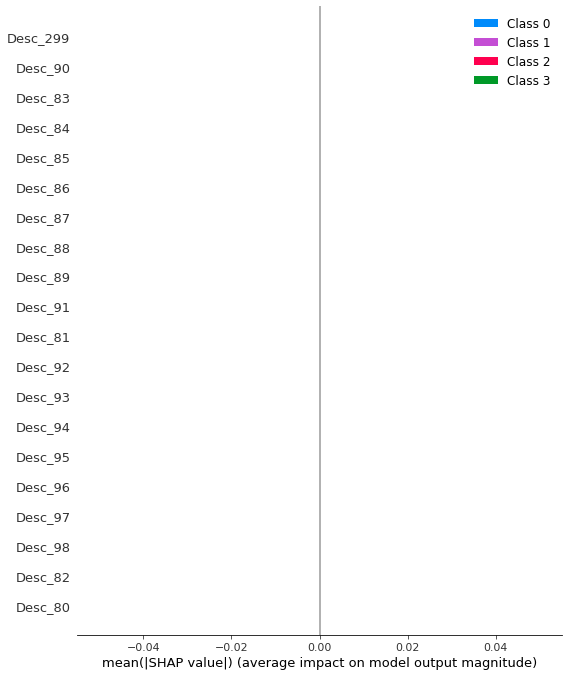

In [125]:
# Kerner Explainer
explainer = shap.KernelExplainer(LR.predict_proba,X[:100])
shap_values = explainer.shap_values(X[:100])
shap.summary_plot(shap_values, X[:100])

Redes Neuronales

In [126]:
from sklearn.neural_network import MLPClassifier
NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1,max_iter=500).fit(X_trainset,y_trainset)

In [127]:
NN_Ss1 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1,max_iter=1000).fit(X_trainset_res_1,y_trainset_res_1)
NN_Ss2 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1,max_iter=1000).fit(X_trainset_res_2,y_trainset_res_2)
NN_Ss3 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1,max_iter=1000).fit(X_trainset_res_3,y_trainset_res_3)
NN_Ss4 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1,max_iter=1000).fit(X_trainset_res_4,y_trainset_res_4)
NN_Ss5 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1,max_iter=1000).fit(X_trainset_res_5,y_trainset_res_5)
NN_OsA = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1,max_iter=1000).fit(X_trainset_res_A,y_trainset_res_A)
NN_OsC = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1,max_iter=1000).fit(X_trainset_res_C,y_trainset_res_C)
NN_OsD = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1,max_iter=1000).fit(X_trainset_res_D,y_trainset_res_D)
NN_OsE = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1,max_iter=1000).fit(X_trainset_res_E,y_trainset_res_E)
NN_ST1 = MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False).fit(X_trainset_res_ST1,y_trainset_res_ST1)
NN_ST2 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1,max_iter=1000).fit(X_trainset_res_ST2,y_trainset_res_ST2)
NN_ST3 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1,max_iter=1000).fit(X_trainset_res_ST3,y_trainset_res_ST3)
NN_ST4 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1,max_iter=1000).fit(X_trainset_res_ST4,y_trainset_res_ST4)
NN_ST5 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1,max_iter=1000).fit(X_trainset_res_ST5,y_trainset_res_ST5)

In [128]:
yhat_4 = NN.predict(X_testset)
print (classification_report(y_testset, yhat_4))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.65      0.35      0.46       456
          C3       0.81      0.94      0.87      1380
          C4       0.00      0.00      0.00        23

    accuracy                           0.78      1861
   macro avg       0.36      0.32      0.33      1861
weighted avg       0.76      0.78      0.75      1861



In [129]:
yhat_4_1 = NN_Ss1.predict(X_testset)
print (classification_report(y_testset, yhat_4_1))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.70      0.02      0.03       456
          C3       0.70      0.19      0.30      1380
          C4       0.01      0.87      0.03        23

    accuracy                           0.15      1861
   macro avg       0.35      0.27      0.09      1861
weighted avg       0.69      0.15      0.23      1861



In [130]:
yhat_4_2 = NN_Ss2.predict(X_testset)
print (classification_report(y_testset, yhat_4_2))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.26      0.94      0.40       456
          C3       0.00      0.00      0.00      1380
          C4       0.04      0.30      0.06        23

    accuracy                           0.23      1861
   macro avg       0.07      0.31      0.12      1861
weighted avg       0.06      0.23      0.10      1861



In [131]:
yhat_4_3 = NN_Ss3.predict(X_testset)
print (classification_report(y_testset, yhat_4_3))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.70      0.02      0.03       456
          C3       0.70      0.19      0.30      1380
          C4       0.01      0.87      0.03        23

    accuracy                           0.15      1861
   macro avg       0.35      0.27      0.09      1861
weighted avg       0.69      0.15      0.23      1861



In [132]:
yhat_4_4 = NN_Ss4.predict(X_testset)
print (classification_report(y_testset, yhat_4_4))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.00      0.00      0.00       456
          C3       0.74      1.00      0.85      1380
          C4       0.00      0.00      0.00        23

    accuracy                           0.74      1861
   macro avg       0.19      0.25      0.21      1861
weighted avg       0.55      0.74      0.63      1861



In [133]:
yhat_4_5 = NN_Ss5.predict(X_testset)
print (classification_report(y_testset, yhat_4_5))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.00      0.00      0.00       456
          C3       0.71      0.21      0.33      1380
          C4       0.01      0.83      0.03        23

    accuracy                           0.17      1861
   macro avg       0.18      0.26      0.09      1861
weighted avg       0.52      0.17      0.24      1861



In [134]:
yhat_4_A = NN_OsA.predict(X_testset)
print (classification_report(y_testset, yhat_4_A))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.26      0.93      0.40       456
          C3       0.89      0.02      0.05      1380
          C4       0.04      0.30      0.07        23

    accuracy                           0.25      1861
   macro avg       0.30      0.31      0.13      1861
weighted avg       0.72      0.25      0.13      1861



In [135]:
yhat_4_C = NN_OsC.predict(X_testset)
print (classification_report(y_testset, yhat_4_C))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.26      0.95      0.40       456
          C3       0.67      0.01      0.01      1380
          C4       0.03      0.22      0.06        23

    accuracy                           0.24      1861
   macro avg       0.24      0.29      0.12      1861
weighted avg       0.56      0.24      0.11      1861



In [136]:
yhat_4_D = NN_OsD.predict(X_testset)
print (classification_report(y_testset, yhat_4_D))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.32      0.36      0.34       456
          C3       0.76      0.68      0.72      1380
          C4       0.05      0.26      0.09        23

    accuracy                           0.60      1861
   macro avg       0.28      0.33      0.29      1861
weighted avg       0.65      0.60      0.62      1861



In [137]:
yhat_4_E = NN_OsE.predict(X_testset)
print (classification_report(y_testset, yhat_4_E))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.37      0.17      0.23       456
          C3       0.75      0.88      0.81      1380
          C4       0.02      0.04      0.03        23

    accuracy                           0.69      1861
   macro avg       0.29      0.27      0.27      1861
weighted avg       0.65      0.69      0.66      1861



In [138]:
yhat_4_ST1 = NN_ST1.predict(X_testset)
print (classification_report(y_testset, yhat_4_ST1))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.52      0.65      0.58       456
          C3       0.87      0.75      0.81      1380
          C4       0.06      0.22      0.09        23

    accuracy                           0.72      1861
   macro avg       0.36      0.41      0.37      1861
weighted avg       0.77      0.72      0.74      1861



In [139]:
yhat_4_ST2 = NN_ST2.predict(X_testset)
print (classification_report(y_testset, yhat_4_ST2))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.22      0.06      0.10       456
          C3       0.74      0.89      0.80      1380
          C4       0.03      0.09      0.04        23

    accuracy                           0.67      1861
   macro avg       0.25      0.26      0.24      1861
weighted avg       0.60      0.67      0.62      1861



In [140]:
yhat_4_ST3 = NN_ST3.predict(X_testset)
print (classification_report(y_testset, yhat_4_ST3))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.36      0.06      0.10       456
          C3       0.75      0.96      0.84      1380
          C4       0.00      0.00      0.00        23

    accuracy                           0.73      1861
   macro avg       0.28      0.26      0.24      1861
weighted avg       0.64      0.73      0.65      1861



In [141]:
yhat_4_ST4 = NN_ST4.predict(X_testset)
print (classification_report(y_testset, yhat_4_ST4))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.42      0.52      0.46       456
          C3       0.79      0.26      0.39      1380
          C4       0.02      0.61      0.03        23

    accuracy                           0.32      1861
   macro avg       0.31      0.35      0.22      1861
weighted avg       0.69      0.32      0.40      1861



In [142]:
yhat_4_ST5 = NN_ST5.predict(X_testset)
print (classification_report(y_testset, yhat_4_ST5))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.25      0.96      0.40       456
          C3       0.89      0.01      0.01      1380
          C4       0.05      0.26      0.08        23

    accuracy                           0.24      1861
   macro avg       0.30      0.31      0.12      1861
weighted avg       0.72      0.24      0.11      1861



In [143]:
yhat_prob_4=NN.predict_proba(X_testset)
NN_Acc=round(metrics.accuracy_score(y_testset, yhat_4),4)
#NN_Jcc=round(jaccard_similarity_score(y_testset, yhat_4),4)
NN_lgl=round(log_loss(y_testset, yhat_prob_4),4)
NN_F1=f1_score(y_testset, yhat_4, average='weighted') 

In [144]:
NN_GS =MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=400,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
NN_GS.fit(X_trainset,y_trainset)

MLPClassifier(max_iter=400, random_state=1, solver='sgd')

In [ ]:
NN_parameters = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],'alpha': [0.0001, 0.05],'learning_rate': ['constant','adaptive'],'max_iter':[300,400]}

NN_GS = GridSearchCV(estimator=NN,param_grid=NN_parameters, cv= 5, verbose=True,scoring="accuracy")
NN_GS.fit(X_trainset,y_trainset)

In [ ]:
NN_GS.best_estimator_

In [145]:
yhat_4_GS= NN_GS.predict(X_testset)
yhat_prob_4_GS=NN_GS.predict_proba(X_testset)
NN_Acc_GS=round(metrics.accuracy_score(y_testset, yhat_4_GS),4)
NN_Acc_ST1=round(metrics.accuracy_score(y_testset, yhat_4_ST1),4)
#NN_Jcc_GS=round(jaccard_similarity_score(y_testset, yhat_4_GS),4)
#NN_lgl_GS=round(log_loss(y_testset, yhat_prob_4_GS),4)
NN_F1_GS=round(f1_score(y_testset, yhat_4_GS, average='weighted'),4) 
NN_F1_ST1=round(f1_score(y_testset, yhat_4_ST1, average='weighted'),4) 

In [146]:
resultados_NN = {'índices de rendimiento':['Accuracy','F1-Score'],
             'Red Neuronal':[NN_Acc,NN_F1],
             'Grid Search':[NN_Acc_GS,NN_F1_GS],
                'Smote-Tomek':[NN_Acc_ST1,NN_F1_ST1]}
Tabla_resultados_NN=pd.DataFrame(resultados_NN)
print(Tabla_resultados_NN)

  índices de rendimiento  Red Neuronal  Grid Search  Smote-Tomek
0               Accuracy       0.78290       0.8044       0.7206
1               F1-Score       0.75496       0.7815       0.7399


In [147]:
data_DF=pd.DataFrame(X, columns=df_cat.columns)

In [148]:
import eli5
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(NN_GS, random_state=1).fit(X, y)
eli5.show_weights(perm, feature_names =data_DF.columns.tolist())

Weight,Feature
0.0007 ± 0.0002,FR
0.0001 ± 0.0003,HGT
0.0000 ± 0.0001,PAC_EDAD
0 ± 0.0000,Desc_86
0 ± 0.0000,Desc_87
0 ± 0.0000,Desc_88
0 ± 0.0000,Desc_89
0 ± 0.0000,Desc_90
0 ± 0.0000,Desc_91
0 ± 0.0000,Desc_98


  0%|          | 0/100 [00:00<?, ?it/s]

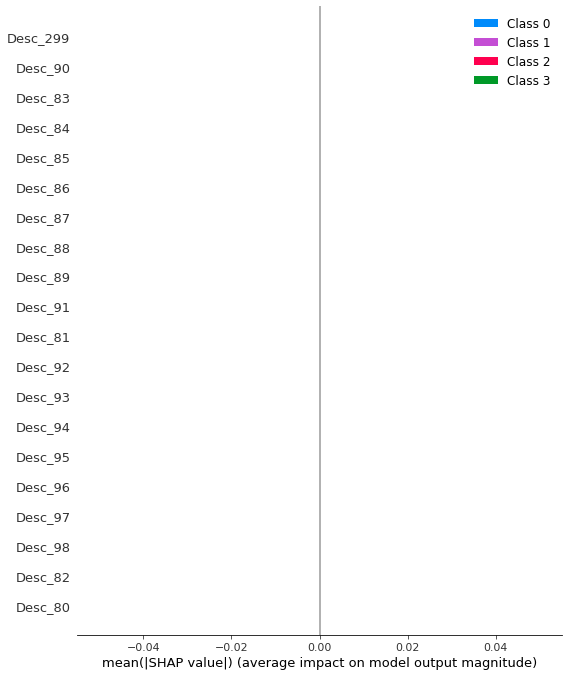

In [149]:
# Kerner Explainer
import shap
explainer = shap.KernelExplainer(NN.predict_proba,data_DF[:100])
shap_values = explainer.shap_values(data_DF[:100])
shap.summary_plot(shap_values, data_DF[:100])

 <h1 id="Matrices de confusión">Matrices de confusión</h1>
<p>
En esta sección se construyen matrices de confusión para evaluar la eficiaca de cada algoritmo
</p>

In [187]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matriz de confusión',
                          cmap=plt.cm.Blues):
    """
    Esta función muestra y dibuja la matriz de confusión.
    La normalización se puede aplicar estableciendo el valor `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusión normalizada")
    else:
        print('Matriz de confusión sin normalización')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Etiqueta Real')
    plt.xlabel('Etiqueta Predicha')


Árbol de decisión

Matriz de confusión sin normalización
              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.97      0.42      0.59       456
          C3       0.83      1.00      0.90      1380
          C4       0.00      0.00      0.00        23

    accuracy                           0.84      1861
   macro avg       0.45      0.35      0.37      1861
weighted avg       0.85      0.84      0.81      1861



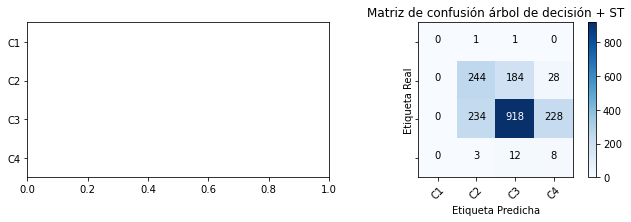

In [188]:
cnf_matrix1 = confusion_matrix(y_testset, yhat_1_ST1, labels=['C1','C2','C3','C4'])
#cnf_matrix2 = confusion_matrix(y_testset, yhat_1_GS, labels=['C1','C2','C3','C4'])
np.set_printoptions(precision=2)
fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
axs[0]=plot_confusion_matrix(cnf_matrix1, classes=['C1','C2','C3','C4'],normalize= False,  title='Matriz de confusión árbol de decisión + ST')
#axs[1]=plot_confusion_matrix(cnf_matrix2, classes=['C1','C2','C3','C4'],normalize= False,  title='Matriz de confusión árbol de decisión')
print (classification_report(y_testset, yhat_1))

Bosque de decisión

Matriz de confusión sin normalización
              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.71      0.08      0.14       456
          C3       0.42      0.02      0.03      1380
          C4       0.01      1.00      0.03        23

    accuracy                           0.04      1861
   macro avg       0.29      0.27      0.05      1861
weighted avg       0.48      0.04      0.06      1861



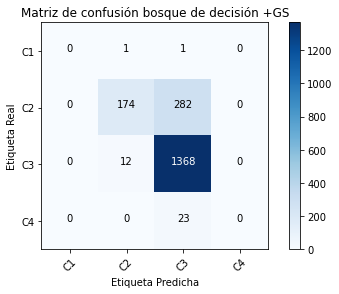

In [189]:
cnf_matrix = confusion_matrix(y_testset, yhat_2_GS, labels=['C1','C2','C3','C4'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['C1','C2','C3','C4'],normalize= False,  title='Matriz de confusión bosque de decisión +GS')
print (classification_report(y_testset,yhat_1_3))

Regresión Logística

Matriz de confusión sin normalización
              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.48      0.63      0.55       456
          C3       0.87      0.66      0.75      1380
          C4       0.02      0.22      0.04        23

    accuracy                           0.65      1861
   macro avg       0.34      0.38      0.33      1861
weighted avg       0.76      0.65      0.69      1861



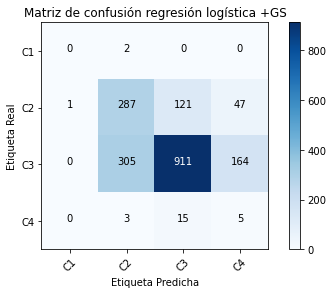

In [190]:
cnf_matrix = confusion_matrix(y_testset, yhat_3_GS, labels=['C1','C2','C3','C4'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['C1','C2','C3','C4'],normalize= False,  title='Matriz de confusión regresión logística +GS')
print (classification_report(y_testset, yhat_3))

Red neuronal

Matriz de confusión sin normalización
              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         2
          C2       0.65      0.35      0.46       456
          C3       0.81      0.94      0.87      1380
          C4       0.00      0.00      0.00        23

    accuracy                           0.78      1861
   macro avg       0.36      0.32      0.33      1861
weighted avg       0.76      0.78      0.75      1861



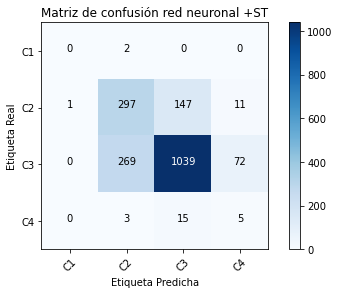

In [191]:
cnf_matrix = confusion_matrix(y_testset, yhat_4_ST1, labels=['C1','C2','C3','C4'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['C1','C2','C3','C4'],normalize= False,  title='Matriz de confusión red neuronal +ST')
print (classification_report(y_testset, yhat_4))